In [ ]:
!wget https://rhyme.com/courses/c1fc65af-ce14-4d5e-8e50-c05e2c48bb35/course_resources 

In [ ]:
!unzip course_resources

### Task 1: Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


## Task 2: Load and Preprocess SETI Data

In [4]:
train_images = pd.read_csv('/content/dataset/train/images.csv', header=None)
train_labels = pd.read_csv('/content/dataset/train/labels.csv', header=None)

val_images = pd.read_csv('/content/dataset/validation/images.csv', header=None)
val_labels = pd.read_csv('/content/dataset/validation/labels.csv', header=None)

In [5]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8152,8153,8154,8155,8156,8157,8158,8159,8160,8161,8162,8163,8164,8165,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,0.729412,0.725490,0.619608,0.674510,0.643137,0.705882,0.713726,0.658824,0.615686,0.690196,0.654902,0.525490,0.556863,0.541176,0.482353,0.588235,0.615686,0.600000,0.603922,0.627451,0.678431,0.658824,0.698039,0.576471,0.678431,0.686275,0.690196,0.705882,0.705882,0.643137,...,0.650980,0.666667,0.666667,0.709804,0.682353,0.682353,0.682353,0.658824,0.682353,0.643137,0.627451,0.623529,0.650980,0.721569,0.627451,0.635294,0.709804,0.690196,0.678431,0.647059,0.658824,0.682353,0.654902,0.694118,0.741176,0.678431,0.662745,0.729412,0.694118,0.647059,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,0.678431,0.709804,0.713726,0.686275,0.717647,0.713726,0.694118,0.690196,0.721569,0.701961,0.698039,0.713726,0.705882,0.756863,0.756863,0.694118,0.650980,0.674510,0.752941,0.725490,0.725490,0.760784,0.678431,0.717647,0.725490,0.682353,0.709804,0.729412,0.721569,0.717647,...,0.686275,0.670588,0.713726,0.733333,0.725490,0.694118,0.694118,0.686275,0.674510,0.729412,0.721569,0.701961,0.682353,0.709804,0.756863,0.698039,0.729412,0.721569,0.674510,0.698039,0.725490,0.733333,0.666667,0.682353,0.701961,0.737255,0.745098,0.725490,0.698039,0.650980,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,0.690196,0.670588,0.662745,0.666667,0.713726,0.701961,0.721569,0.713726,0.662745,0.698039,0.682353,0.639216,0.717647,0.658824,0.674510,0.639216,0.643137,0.635294,0.654902,0.682353,0.639216,0.733333,0.690196,0.658824,0.686275,0.658824,0.690196,0.698039,0.709804,0.650980,...,0.533333,0.572549,0.537255,0.549020,0.670588,0.690196,0.670588,0.643137,0.662745,0.713726,0.717647,0.721569,0.709804,0.674510,0.709804,0.686275,0.658824,0.694118,0.698039,0.694118,0.678431,0.678431,0.690196,0.662745,0.650980,0.650980,0.686275,0.631373,0.666667,0.701961,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,0.631373,0.650980,0.670588,0.737255,0.674510,0.615686,0.670588,0.705882,0.686275,0.678431,0.694118,0.647059,0.662745,0.682353,0.654902,0.721569,0.709804,0.631373,0.670588,0.674510,0.701961,0.725490,0.666667,0.647059,0.733333,0.682353,0.678431,0.603922,0.666667,0.713726,...,0.670588,0.705882,0.749020,0.662745,0.564706,0.623529,0.674510,0.709804,0.658824,0.631373,0.705882,0.670588,0.658824,0.690196,0.674510,0.658824,0.635294,0.682353,0.682353,0.639216,0.666667,0.654902,0.647059,0.670588,0.682353,0.639216,0.705882,0.729412,0.674510,0.666667,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,0.631373,0.709804,0.694118,0.698039,0.666667,0.690196,0.690196,0.682353,0.682353,0.647059,0.678431,0.658824,0.760784,0.729412,0.674510,0.694118,0.698039,0.713726,0.690196,0.698039,0.686275,0.705882,0.662745,0.670588,0.705882,0.682353,0.690196,0.733333,0.709804,0.701961,...,0.639216,0.690196,0.662745,0.658824,0.662745,0.698039,0.603922,0.690196,0.627451,0.627451,0.654902,0.725490,0.650980,0.717647,0.666667,0.709804,0.682353,0.674510,0.721569,0.741176,0.635294,0.615686,0.674510,0.690196,0.658824,0.694118,0.701961,0.670588,0.721569,0.780392,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [6]:
train_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [7]:
print("Training set shape:", train_images.shape, train_labels.shape)
print("Validation set shape:", val_images.shape, val_labels.shape)

Training set shape: (3200, 8192) (3200, 4)
Validation set shape: (800, 8192) (800, 4)


In [8]:
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

## Task 3: Plot 2D Spectrograms

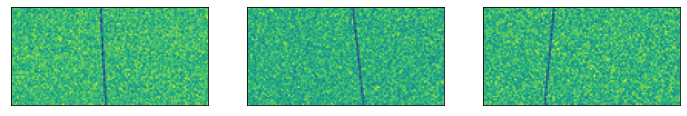

In [9]:
plt.figure(0, figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = np.squeeze(x_train[np.random.randint(0, x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

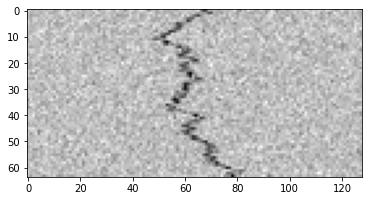

In [10]:
plt.imshow(np.squeeze(x_train[3]), cmap="gray");

## Task 4: Create Training and Validation Data Generators

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

## Task 5: Creating the CNN Model


In [12]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [13]:
# Initialising the CNN
model = Sequential()

# 1st Convolution
model.add(Conv2D(32,(5,5), padding='same', input_shape=(64, 128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax'))

## Task 6: Learning Rate Scheduling and Compile the Model

In [14]:
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

In [15]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        2

## Task 7: Training the Model

In [16]:

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss',
                             save_weights_only=True, mode='min', verbose=0)
callbacks = [checkpoint]#, reduce_lr]
batch_size = 32
history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val)//batch_size,
    epochs=12,
    callbacks=callbacks
)

Epoch 1/12
100/100 [==============================] - 3s 28ms/step - loss: 0.6018 - accuracy: 0.6866 - val_loss: 3.0200 - val_accuracy: 0.2500
Epoch 2/12
100/100 [==============================] - 3s 26ms/step - loss: 0.4069 - accuracy: 0.7397 - val_loss: 3.8424 - val_accuracy: 0.2500
Epoch 3/12
100/100 [==============================] - 3s 27ms/step - loss: 0.3904 - accuracy: 0.7522 - val_loss: 4.4040 - val_accuracy: 0.2500
Epoch 4/12
100/100 [==============================] - 3s 26ms/step - loss: 0.3882 - accuracy: 0.7375 - val_loss: 3.4995 - val_accuracy: 0.4700
Epoch 5/12
100/100 [==============================] - 3s 27ms/step - loss: 0.3762 - accuracy: 0.7475 - val_loss: 3.0872 - val_accuracy: 0.4988
Epoch 6/12
100/100 [==============================] - 3s 26ms/step - loss: 0.3706 - accuracy: 0.7503 - val_loss: 2.3689 - val_accuracy: 0.5013
Epoch 7/12
100/100 [==============================] - 3s 27ms/step - loss: 0.3717 - accuracy: 0.7484 - val_loss: 1.6816 - val_accuracy: 0.5063

## Task 8: Model Evaluation

In [17]:
model.evaluate(x_val, y_val)

25/25 [==============================] - 0s 6ms/step - loss: 0.3650 - accuracy: 0.7513


[0.3649517893791199, 0.7512500286102295]

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)
print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.50      0.94      0.65       200
           2       0.55      0.09      0.15       200
           3       1.00      1.00      1.00       200

    accuracy                           0.75       800
   macro avg       0.76      0.75      0.70       800
weighted avg       0.76      0.75      0.70       800

Classification accuracy: 0.751250


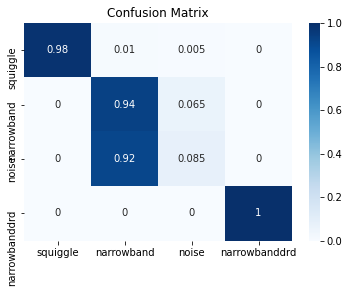

In [19]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax = ax, cmap=plt.cm.Blues); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);